# Technical Analysis: Part 1 -- Unsupervised Machine Learning

- There are numerous target variables. I will conduct PCA over target variables in order to reduce dimensionality and find most significant target variables to focus on.
- There are numerous features in the dataset. I will conduct PCA over feature variables in order to reduce dimensionality and find most significant target variables to focus on.
- Based on EDA, states and delinquent status should be included as features. 


Outline of Approach:

1) Preprocess data and establish features from targets

2) PCA over target (y) variables
- y-correlation
- PC1 vs PC2
- PC1 vs target variables
- PC2 vs target variables
    - PC1 vs PC2 WITH LABELS (using covariance matrix)

3) PCA over features (x) variables
- x-correlation
- PC1 vs PC2
- PC1 vs features variables
- PC2 vs features variables
    - PC1 vs PC2 WITH LABELS (using covariance matrix)

In [14]:
# Load necessary libraries and tools...

In [15]:
import pandas as pd
import seaborn as sns
import numpy as np
from matplotlib import pyplot as plt
import math
import psycopg2 as psy
from sqlalchemy import create_engine
from sqlalchemy.engine.url import URL
import pandas.io.sql as psql
%matplotlib inline


In [16]:
# Loading data from csv files...

In [17]:
cohort_1_w1w2 = pd.read_csv('/Users/cguy/kelstuff/ga_summer_2016/cohort_1_w1w2.csv')
cohort_1_w1w2.head()

,Unnamed: 0,AcSuppSv,AgeMP,AmIAKN,Asian,Baseline,BlkAfrAm,BudgetSv,CareerSv,CurrFTE,...,Sex,SpecEdSv,St,StFCID,StFIPS,SubAbuse,TribeSv,Wave,Weight,White
0,0,0.0,17.0,0.0,0.0,Yes,0.0,0.0,0.0,No,...,2.0,0.0,AK,AK450290395006,2.0,Yes,0.0,Wave 1: Age 17 Baseline Survey,1.26,1.0
1,4,0.0,17.0,1.0,0.0,Yes,0.0,0.0,0.0,No,...,2.0,0.0,AK,AK450448396586,2.0,No,1.0,Wave 1: Age 17 Baseline Survey,1.36,0.0
2,10,0.0,17.0,0.0,0.0,Yes,0.0,0.0,0.0,No,...,2.0,0.0,AK,AK450540097503,2.0,No,0.0,Wave 1: Age 17 Baseline Survey,1.26,1.0
3,14,0.0,17.0,0.0,0.0,Yes,0.0,0.0,0.0,No,...,1.0,0.0,AK,AK450652098623,2.0,No,0.0,Wave 1: Age 17 Baseline Survey,3.31,1.0
4,17,0.0,17.0,1.0,0.0,Yes,0.0,0.0,0.0,No,...,2.0,1.0,AK,AK451448406587,2.0,No,1.0,Wave 1: Age 17 Baseline Survey,1.36,0.0


In [29]:
cohort_1_w1w2.columns

Index([u'Unnamed: 0', u'AcSuppSv', u'AgeMP', u'AmIAKN', u'Asian', u'Baseline',
       u'BlkAfrAm', u'BudgetSv', u'CareerSv', u'CurrFTE', u'CurrPTE',
       u'CurrenRoll', u'DOB', u'DelinqntSv', u'EdLevlSv', u'EducFinaSv',
       u'Elig19', u'EmplyTrSv', u'FCStatSv', u'FY', u'FY11Cohort',
       u'FamSuppSv', u'HawaiiPI', u'HighEdCert', u'HisOrgin', u'HlthEdSv',
       u'Homeless', u'HousEdSv', u'ILNAsv', u'InSample', u'Incarc',
       u'Medicaid', u'MedicalIn', u'MentlHlthIn', u'MentorSv', u'Num_services',
       u'OthrFinAs', u'OthrFinaSv', u'OthrHlthIn', u'OutcmDte', u'OutcmFCS',
       u'OutcmRpt', u'PSEdSuppSv', u'PrescripIn', u'PubFinAs', u'PubFoodAs',
       u'PubHousAs', u'Race', u'RaceDcln', u'RaceEthn', u'RaceUnkn',
       u'RepDate_outcomes', u'RepDate_services', u'Responded', u'RmBrdFASv',
       u'SILsv', u'SampleState', u'Sex', u'SpecEdSv', u'St', u'StFCID',
       u'StFIPS', u'SubAbuse', u'TribeSv', u'Wave', u'Weight', u'White'],
      dtype='object')

# 1) Preprocess data and separate target variables from feature variables

In [30]:
# Seperate dataframe into feature vars and target vars

targets = cohort_1_w1w2[['CurrenRoll','HighEdCert', 'Wave']]


features = cohort_1_w1w2[['ILNAsv','AcSuppSv','PSEdSuppSv','CareerSv','EmplyTrSv','BudgetSv','HousEdSv','HlthEdSv',\
                     'FamSuppSv','MentorSv','SILsv','RmBrdFASv','EducFinaSv','OthrFinaSv','St','DelinqntSv','Wave']]


In [31]:
# # Create column for number of services received

services_count = features.T
services_count = services_count.drop('Wave')
services_count = services_count.drop('St')
services_count = services_count.drop('DelinqntSv')


features['Num_services'] = (services_count == 1).sum()
features.head(10)

/Users/cguy/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


,ILNAsv,AcSuppSv,PSEdSuppSv,CareerSv,EmplyTrSv,BudgetSv,HousEdSv,HlthEdSv,FamSuppSv,MentorSv,SILsv,RmBrdFASv,EducFinaSv,OthrFinaSv,St,DelinqntSv,Wave,Num_services
0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,AK,0.0,Wave 1: Age 17 Baseline Survey,2
1,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,AK,0.0,Wave 1: Age 17 Baseline Survey,1
2,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,AK,0.0,Wave 1: Age 17 Baseline Survey,3
3,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,AK,0.0,Wave 1: Age 17 Baseline Survey,1
4,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,AK,0.0,Wave 1: Age 17 Baseline Survey,2
5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,AK,0.0,Wave 1: Age 17 Baseline Survey,1
6,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,AK,0.0,Wave 1: Age 17 Baseline Survey,4
7,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,AK,0.0,Wave 1: Age 17 Baseline Survey,2
8,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,AK,0.0,Wave 1: Age 17 Baseline Survey,1
9,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,AK,0.0,Wave 1: Age 17 Baseline Survey,2


In [32]:
#  # with num_services and state as one feature

from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()

features_2 = features.copy()

features_w2_original = features_2[features_2.Wave == "Wave 2: Age 19 Followup"]
features_w2_original = features_w2_original.drop('Wave', axis = 1)

features_w2_original['St'] = le.fit_transform(features_w2_original['St'])

features_w2_original.head()

,ILNAsv,AcSuppSv,PSEdSuppSv,CareerSv,EmplyTrSv,BudgetSv,HousEdSv,HlthEdSv,FamSuppSv,MentorSv,SILsv,RmBrdFASv,EducFinaSv,OthrFinaSv,St,DelinqntSv,Num_services
7328,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0,0.0,2
7329,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0,1
7330,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0,0.0,3
7331,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0,1
7332,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0,0.0,2


In [33]:
    # with num_services and states as dummies

features_2 = features.copy()

features_w2_stDums = features_2[features_2.Wave == "Wave 2: Age 19 Followup"]
features_w2_stDums = features_w2_stDums.drop('Wave', axis = 1)

features_w2_stDums = pd.get_dummies(features_w2_stDums)

features_w2_stDums.head()



,ILNAsv,AcSuppSv,PSEdSuppSv,CareerSv,EmplyTrSv,BudgetSv,HousEdSv,HlthEdSv,FamSuppSv,MentorSv,...,St_RI,St_SC,St_SD,St_UT,St_VA,St_VT,St_WA,St_WI,St_WV,St_WY
7328,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7329,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7330,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7331,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7332,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [34]:
features_w2_stDums.columns

Index([u'ILNAsv', u'AcSuppSv', u'PSEdSuppSv', u'CareerSv', u'EmplyTrSv',
       u'BudgetSv', u'HousEdSv', u'HlthEdSv', u'FamSuppSv', u'MentorSv',
       u'SILsv', u'RmBrdFASv', u'EducFinaSv', u'OthrFinaSv', u'DelinqntSv',
       u'Num_services', u'St_AK', u'St_AL', u'St_AR', u'St_AZ', u'St_CA',
       u'St_CO', u'St_DC', u'St_DE', u'St_FL', u'St_GA', u'St_IA', u'St_ID',
       u'St_IL', u'St_KS', u'St_LA', u'St_MA', u'St_MD', u'St_ME', u'St_MI',
       u'St_MN', u'St_MO', u'St_MT', u'St_NC', u'St_ND', u'St_NE', u'St_NH',
       u'St_NJ', u'St_NM', u'St_NV', u'St_NY', u'St_OH', u'St_OK', u'St_RI',
       u'St_SC', u'St_SD', u'St_UT', u'St_VA', u'St_VT', u'St_WA', u'St_WI',
       u'St_WV', u'St_WY'],
      dtype='object')

In [35]:
    # withOUT num_services and states as dummies

features_noNum_stDums = features_w2_stDums.copy()

features_noNum_stDums = features_noNum_stDums.drop('Num_services', axis = 1)

features_noNum_stDums.head()


,ILNAsv,AcSuppSv,PSEdSuppSv,CareerSv,EmplyTrSv,BudgetSv,HousEdSv,HlthEdSv,FamSuppSv,MentorSv,...,St_RI,St_SC,St_SD,St_UT,St_VA,St_VT,St_WA,St_WI,St_WV,St_WY
7328,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7329,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7330,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7331,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7332,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [36]:
# withOUT num_services and state as one feature

features_noNum_st_one = features_w2_original.copy()

features_noNum_st_one = features_noNum_st_one.drop('Num_services', axis = 1)

features_noNum_st_one.head()


,ILNAsv,AcSuppSv,PSEdSuppSv,CareerSv,EmplyTrSv,BudgetSv,HousEdSv,HlthEdSv,FamSuppSv,MentorSv,SILsv,RmBrdFASv,EducFinaSv,OthrFinaSv,St,DelinqntSv
7328,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0,0.0
7329,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0
7330,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0,0.0
7331,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0
7332,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0,0.0


In [37]:
# withOUT states and with num_services
    
features_noSt = features.copy()

features_noSt = features_noSt[features_noSt.Wave == "Wave 2: Age 19 Followup"]
features_noSt = features_noSt.drop('Wave', axis = 1)
features_noSt = features_noSt.drop('St', axis = 1)

features_noSt.head()


,ILNAsv,AcSuppSv,PSEdSuppSv,CareerSv,EmplyTrSv,BudgetSv,HousEdSv,HlthEdSv,FamSuppSv,MentorSv,SILsv,RmBrdFASv,EducFinaSv,OthrFinaSv,DelinqntSv,Num_services
7328,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,2
7329,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
7330,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,3
7331,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
7332,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,2


In [38]:
# withOUT states and Num_services

features_noSt_noNum = features_noSt.copy()

features_noSt_noNum = features_noSt_noNum.drop('Num_services', axis = 1)

features_noSt_noNum.head()


,ILNAsv,AcSuppSv,PSEdSuppSv,CareerSv,EmplyTrSv,BudgetSv,HousEdSv,HlthEdSv,FamSuppSv,MentorSv,SILsv,RmBrdFASv,EducFinaSv,OthrFinaSv,DelinqntSv
7328,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
7329,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7330,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0
7331,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7332,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


In [39]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()

targets_w2_ = targets[targets.Wave == "Wave 2: Age 19 Followup"]
targets_w2_ = targets_w2_.drop('Wave', axis = 1)


targets_w2 = targets_w2_.copy()

for column in targets_w2:
    targets_w2[column] = le.fit_transform(targets_w2[column])
targets_w2.head()

,CurrenRoll,HighEdCert
7328,2,7
7329,2,5
7330,3,5
7331,2,5
7332,2,5


In [47]:
targets_labels = targets[targets.Wave == "Wave 2: Age 19 Followup"]

targets_labels.HighEdCert.value_counts()

Blank                      2813
High school diploma/GED    2508
None of the above          1705
Declined                     95
Vocational certificate       62
Vocational license           19
Associate's Degree            7
Higher degree                 7
Bachelor's Degree             2
Name: HighEdCert, dtype: int64

In [42]:
targets_w2.HighEdCert.value_counts()

3    2813
5    2508
7    1705
0     110
4      95
8      62
9      19
6       7
1       7
2       2
Name: HighEdCert, dtype: int64

In [48]:
targets_labels.CurrenRoll.value_counts()

Blank       2808
Yes         2447
No          1996
Declined      77
Name: CurrenRoll, dtype: int64

In [43]:
targets_w2.CurrenRoll.value_counts()

0    2808
3    2447
2    1996
1      77
Name: CurrenRoll, dtype: int64

In [51]:
# y = 0 v 1, 
    # where 1 = Vocational certificate (8), Vocational license (9), Associate's Degree (6), 
            #   Higher degree (1), Bachelor's Degree (2)
    # or 1 = when CurrenRoll == 3

def determine_Success(row):
    column_1 = 'HighEdCert'
    column_2 = 'CurrenRoll'
    if row[column_1] == 1:
        val = 1
    elif row[column_1] ==  2:
        val = 1
    elif row[column_1] ==  6:
        val = 1
    elif row[column_1] ==  9:
        val = 1
    elif row[column_1] ==  8:
        val = 1
    elif row[column_2] == 3:
        val = 1
    else:
        val = 0
    return val
    
targets_w2_final = targets_w2.copy()

targets_w2_final['Success'] = targets_w2_final.apply(determine_Success, axis=1)
targets_w2_final.head(10)



,CurrenRoll,HighEdCert,Success
7328,2,7,0
7329,2,5,0
7330,3,5,1
7331,2,5,0
7332,2,5,0
7333,3,7,1
7334,3,7,1
7335,2,5,0
7336,2,7,0
7337,3,7,1


In [52]:
targets_w2_final['Success'].value_counts()

0    4830
1    2498
Name: Success, dtype: int64

# 2) PCA over features, with num_services and states as dummies

In [ ]:
# ALREADY DONE:
#  # with num_services and state as one feature
features_w2_original

# with num_services and states as dummies
features_w2_stDums







# withOUT num_services and states as dummies
features_noNum_stDums

# withOUT num_services and state as one feature
features_noNum_st_one

# withOUT states and with num_services
features_noSt

# withOUT states and Num_services
features_noSt_noNum

In [79]:
# y-correlations

y_corr = np.corrcoef(features_noSt.values.T)
features_noSt.corr()

,ILNAsv,AcSuppSv,PSEdSuppSv,CareerSv,EmplyTrSv,BudgetSv,HousEdSv,HlthEdSv,FamSuppSv,MentorSv,SILsv,RmBrdFASv,EducFinaSv,OthrFinaSv,DelinqntSv,Num_services
ILNAsv,1.000000,0.998852,0.999198,0.999006,0.999071,0.999044,0.999033,0.999059,0.999034,0.999128,0.999318,0.999379,0.999255,0.999129,0.999204,-0.241584
AcSuppSv,0.998852,1.000000,0.999307,0.999233,0.999277,0.999177,0.999200,0.999248,0.999216,0.999249,0.999354,0.999376,0.999287,0.999174,0.999179,-0.234288
PSEdSuppSv,0.999198,0.999307,1.000000,0.999427,0.999443,0.999379,0.999404,0.999363,0.999400,0.999426,0.999575,0.999604,0.999583,0.999471,0.999350,-0.237396
CareerSv,0.999006,0.999233,0.999427,1.000000,0.999340,0.999379,0.999344,0.999363,0.999321,0.999275,0.999389,0.999420,0.999356,0.999252,0.999172,-0.230502
EmplyTrSv,0.999071,0.999277,0.999443,0.999340,1.000000,0.999359,0.999345,0.999333,0.999342,0.999380,0.999498,0.999524,0.999467,0.999360,0.999308,-0.235841
BudgetSv,0.999044,0.999177,0.999379,0.999379,0.999359,1.000000,0.999461,0.999428,0.999347,0.999297,0.999412,0.999456,0.999358,0.999238,0.999202,-0.231174
HousEdSv,0.999033,0.999200,0.999404,0.999344,0.999345,0.999461,1.000000,0.999409,0.999368,0.999268,0.999438,0.999448,0.999353,0.999271,0.999223,-0.230791
HlthEdSv,0.999059,0.999248,0.999363,0.999363,0.999333,0.999428,0.999409,1.000000,0.999421,0.999315,0.999395,0.999444,0.999348,0.999251,0.999222,-0.229853
FamSuppSv,0.999034,0.999216,0.999400,0.999321,0.999342,0.999347,0.999368,0.999421,1.000000,0.999370,0.999438,0.999498,0.999403,0.999329,0.999325,-0.232982
MentorSv,0.999128,0.999249,0.999426,0.999275,0.999380,0.999297,0.999268,0.999315,0.999370,1.000000,0.999559,0.999591,0.999510,0.999436,0.999368,-0.239316


In [80]:
# Obtaining eigenvalues and eigenvectors for PCA

eig_vals, eig_vecs = np.linalg.eig(y_corr)
print eig_vals
print eig_vecs


[  1.50512647e+01   9.40213120e-01   1.18132135e-03   9.33553406e-04
   8.57223960e-04   2.19920652e-04   2.62302083e-04   3.50904400e-04
   7.63859594e-04   4.66167295e-04   6.54818007e-04   6.25419104e-04
   6.05245932e-04   5.66610810e-04   5.24493772e-04   5.10388886e-04]
[[  2.57607943e-01  -1.27118370e-02  -8.63549258e-01   1.59544345e-02
   -3.47002027e-01   4.79575793e-02   8.20036608e-02  -7.07869097e-02
   -9.65620812e-02  -1.11763954e-01  -1.43111821e-02   3.68791307e-02
   -3.44582718e-02   7.95781751e-02   1.47907886e-01  -1.67890318e-02]
 [  2.57600537e-01  -2.04939850e-02   4.27124465e-01  -2.89977746e-01
   -7.43010605e-01   8.61208156e-03   8.00168153e-02  -4.24502896e-02
   -5.51970108e-02  -1.06940962e-01  -1.36380765e-01   2.24747915e-01
    1.87485945e-02  -6.38516155e-03   7.07370181e-02  -1.31778189e-01]
 [  2.57661979e-01  -1.72408653e-02   1.46517294e-02  -1.09547052e-01
    1.06899085e-01  -3.11364381e-02  -1.02771523e-03  -2.62262125e-01
   -2.70983685e-01   

In [81]:
# Obtaining cumulative explained variance

tot = sum(eig_vals)
var_exp = [(i / tot)*100 for i in sorted(eig_vals, reverse=True)]
cum_var_exp = np.cumsum(var_exp)
print cum_var_exp

[ 94.07040407  99.94673607  99.95411933  99.95995403  99.96531168
  99.97008581  99.97417842  99.97808729  99.98187008  99.98541139
  99.98868948  99.99187941  99.99479296  99.99698611  99.9986255  100.        ]


In [82]:
# From output of cell above, we can see 
# that the first two principal components explain 92.6% of the variance in the target variables

In [83]:
# Obtaining eigenpairs...

value_vector_pairs = [[eig_vals[i], eig_vecs[:,i]] for i in range(len(eig_vals))]
value_vector_pairs.sort(reverse=True)

In [84]:
# Transforming eigen data to obtain 2d PCA projection matrix in order to plot principal components

weight_2d_projection = np.hstack((value_vector_pairs[0][1].reshape(eig_vecs.shape[1],1),
                                  value_vector_pairs[1][1].reshape(eig_vecs.shape[1],1)))

print 'Weight data 2d PCA projection matrix:\n', weight_2d_projection

Weight data 2d PCA projection matrix:
[[ 0.25760794 -0.01271184]
 [ 0.25760054 -0.02049398]
 [ 0.25766198 -0.01724087]
 [ 0.25760372 -0.02453717]
 [ 0.25764008 -0.01887747]
 [ 0.25761108 -0.02382952]
 [ 0.2576099  -0.02423507]
 [ 0.25760638 -0.02523289]
 [ 0.25762365 -0.02191126]
 [ 0.25765735 -0.01518676]
 [ 0.25772032 -0.00706157]
 [ 0.25771273 -0.01115739]
 [ 0.2576939  -0.01145849]
 [ 0.25766643 -0.01258582]
 [ 0.25767986 -0.00664944]
 [-0.06538379 -0.99757297]]


In [85]:
Z = features_noSt.dot(weight_2d_projection)


### PC1 vs PC2

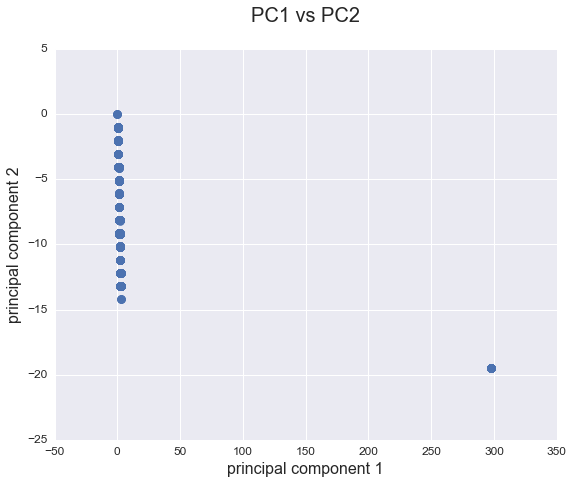

In [86]:
fig = plt.figure(figsize=(9,7))

ax = fig.gca()
ax = sns.regplot(Z.iloc[:,0], Z.iloc[:,1],
                 fit_reg=False, scatter_kws={'s':70}, ax=ax)

ax.set_xlabel('principal component 1', fontsize=16)
ax.set_ylabel('principal component 2', fontsize=16)


for tick in ax.xaxis.get_major_ticks():
    tick.label.set_fontsize(12) 
    
for tick in ax.yaxis.get_major_ticks():
    tick.label.set_fontsize(12) 
    
ax.set_title('PC1 vs PC2\n', fontsize=20)

plt.show()

In [87]:
# Will now transform data so that PC1 and PC2 can be plotted with individual target variables...
# Need to do this in order to see which variables are more likely part of the principal components...

features_noSt_pcs = features_noSt.copy()

features_noSt_pcs = (features_noSt - features_noSt.mean()) / features_noSt.std()

features_noSt_pcs['PC1'] = Z.iloc[:,0]
features_noSt_pcs['PC2'] = Z.iloc[:,1]

In [88]:
features_noSt_pcs = pd.melt(features_noSt_pcs, id_vars=['PC1','PC2'])


In [89]:
features_noSt_pcs.head()

,PC1,PC2,variable,value
0,0.384509,-2.031967,ILNAsv,-0.235242
1,0.192224,-1.010285,ILNAsv,-0.167430
2,0.576817,-3.029475,ILNAsv,-0.167430
3,0.192224,-1.010285,ILNAsv,-0.167430
4,0.384507,-2.020444,ILNAsv,-0.167430


### PC1 vs Target Variables

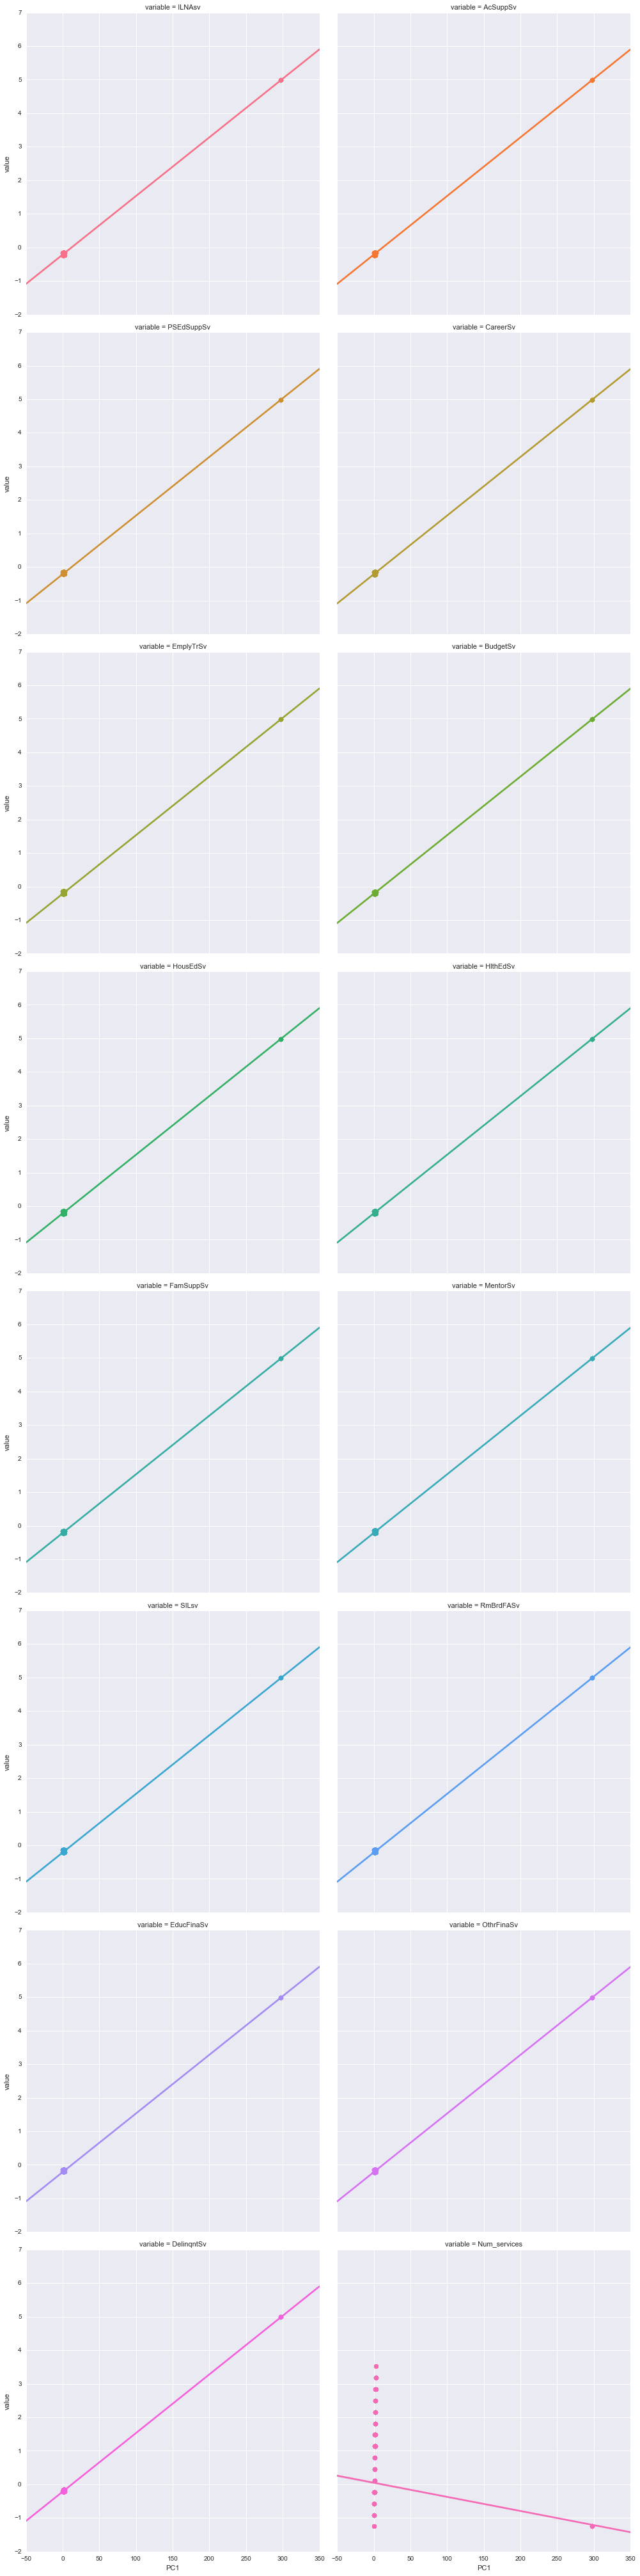

In [90]:
pc1 = sns.lmplot(x="PC1", y="value", col="variable", hue="variable", 
                 data=features_noSt_pcs, col_wrap=2, size=7, scatter_kws={'s':50})

### PC2 vs Target Variables

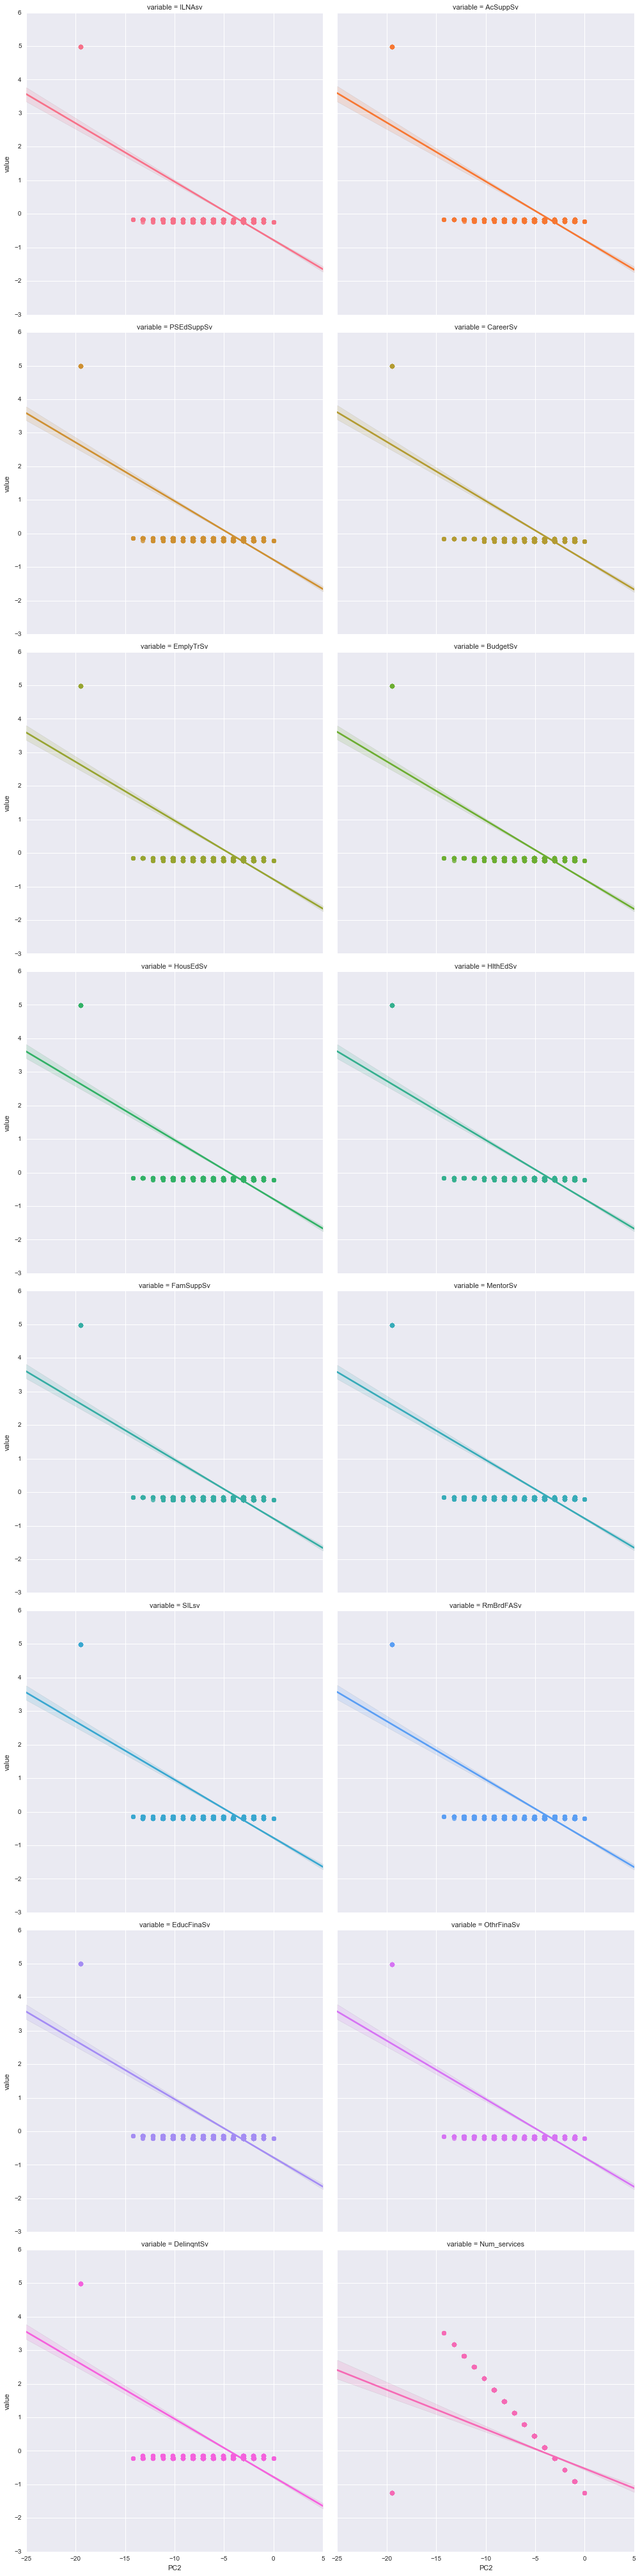

In [91]:
pc2 = sns.lmplot(x="PC2", y="value", col="variable", hue="variable", 
                 data=features_noSt_pcs, col_wrap=2, size=7, scatter_kws={'s':50})


In [22]:
# From the PCAs so far, can see that HighEdCert should be the target variable for this project

### PC1 vs PC2 WITH LABELS

In [23]:
from sklearn.decomposition import PCA 

pcask = PCA(n_components=2)
print pcask.fit(features_noSt).components_ # See the eigenvectors
yPC = pcask.fit_transform(features_noSt) # Use the eigenvectors to transform xStand onto new axes

PCdf = pd.DataFrame(yPC, columns=['PC1','PC2'])

features_noSt_2 = features_noSt

features_noSt_pcs = features_noSt_2.join(PCdf, on=None, how='left')

[[-0.24132997 -0.2118988  -0.18364068 -0.23836743 -0.18045001 -0.19166072
  -0.21702861 -0.21897984 -0.3510533  -0.18732218 -0.18280779 -0.18748198
  -0.31822139 -0.26241788 -0.35217689 -0.34772606]
 [-0.02747461 -0.06436903 -0.03683873  0.96596851 -0.06868541 -0.06498501
  -0.05865357  0.00950304 -0.10833398 -0.01090734 -0.03362602 -0.02332586
  -0.05565659 -0.08583937 -0.11526432 -0.10438531]]


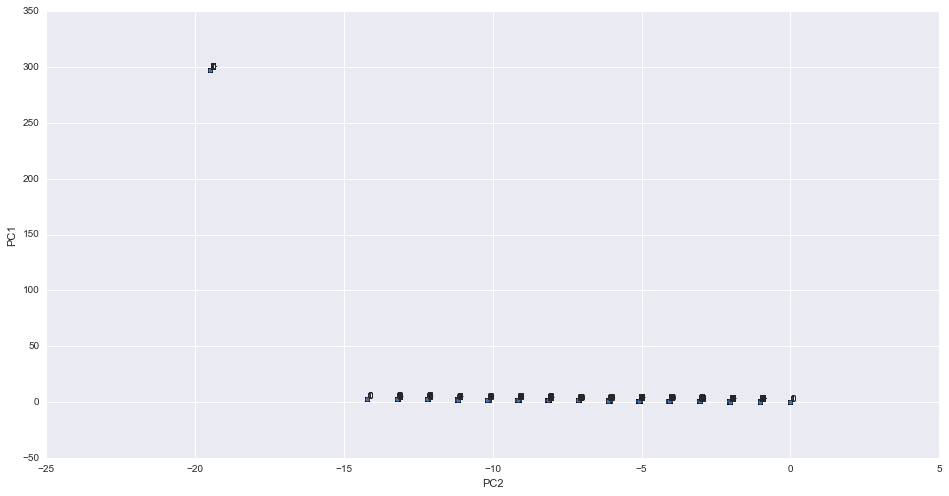

In [93]:
graph = features_noSt_pcs.plot(kind='scatter', x='PC2', y='PC1', figsize=(16,8))

for i, target in enumerate(targets_w2_final['Success']):
    graph.annotate(target, (features_noSt_pcs.iloc[i].PC2, features_noSt_pcs.iloc[i].PC1))

# 3) PCA over features, withOUT num_services and withOUT states

In [ ]:
features_noSt_noNum



In [26]:
# x-correlations

In [94]:
x_corr = np.corrcoef(features_noSt_noNum.values.T)
features_noSt_noNum.corr()

,ILNAsv,AcSuppSv,PSEdSuppSv,CareerSv,EmplyTrSv,BudgetSv,HousEdSv,HlthEdSv,FamSuppSv,MentorSv,SILsv,RmBrdFASv,EducFinaSv,OthrFinaSv,DelinqntSv
ILNAsv,1.000000,0.998852,0.999198,0.999006,0.999071,0.999044,0.999033,0.999059,0.999034,0.999128,0.999318,0.999379,0.999255,0.999129,0.999204
AcSuppSv,0.998852,1.000000,0.999307,0.999233,0.999277,0.999177,0.999200,0.999248,0.999216,0.999249,0.999354,0.999376,0.999287,0.999174,0.999179
PSEdSuppSv,0.999198,0.999307,1.000000,0.999427,0.999443,0.999379,0.999404,0.999363,0.999400,0.999426,0.999575,0.999604,0.999583,0.999471,0.999350
CareerSv,0.999006,0.999233,0.999427,1.000000,0.999340,0.999379,0.999344,0.999363,0.999321,0.999275,0.999389,0.999420,0.999356,0.999252,0.999172
EmplyTrSv,0.999071,0.999277,0.999443,0.999340,1.000000,0.999359,0.999345,0.999333,0.999342,0.999380,0.999498,0.999524,0.999467,0.999360,0.999308
BudgetSv,0.999044,0.999177,0.999379,0.999379,0.999359,1.000000,0.999461,0.999428,0.999347,0.999297,0.999412,0.999456,0.999358,0.999238,0.999202
HousEdSv,0.999033,0.999200,0.999404,0.999344,0.999345,0.999461,1.000000,0.999409,0.999368,0.999268,0.999438,0.999448,0.999353,0.999271,0.999223
HlthEdSv,0.999059,0.999248,0.999363,0.999363,0.999333,0.999428,0.999409,1.000000,0.999421,0.999315,0.999395,0.999444,0.999348,0.999251,0.999222
FamSuppSv,0.999034,0.999216,0.999400,0.999321,0.999342,0.999347,0.999368,0.999421,1.000000,0.999370,0.999438,0.999498,0.999403,0.999329,0.999325
MentorSv,0.999128,0.999249,0.999426,0.999275,0.999380,0.999297,0.999268,0.999315,0.999370,1.000000,0.999559,0.999591,0.999510,0.999436,0.999368


In [95]:
# Obtaining eigenvalues and eigenvectors for PCA

eig_valsX, eig_vecsX = np.linalg.eig(x_corr)
print eig_valsX
print eig_vecsX

[  1.49909372e+01   1.44250447e-03   1.07409326e-03   2.20617390e-04
   8.59091197e-04   3.02412908e-04   3.75617051e-04   7.71068544e-04
   4.68242651e-04   5.10841122e-04   5.38920205e-04   6.65527443e-04
   5.84209606e-04   6.33340395e-04   6.16342505e-04]
[[  2.58143320e-01   5.39998679e-01   6.41684474e-01  -5.63757297e-02
    3.68154720e-01   3.81894827e-02   7.35816033e-02   1.30882254e-01
   -1.04399358e-01   3.43162932e-02   1.24062898e-01  -7.35295667e-02
   -1.18619947e-01  -1.20511858e-01   7.62671727e-02]
 [  2.58167760e-01  -2.53707926e-01  -4.07757506e-01  -1.82904512e-02
    7.70084408e-01   3.77755213e-02   4.12924926e-02   4.85511228e-02
   -1.05815471e-01   1.38089772e-01   5.75119609e-02   8.05320505e-02
   -3.84921906e-03  -2.27950029e-01  -1.08751719e-01]
 [  2.58215996e-01   1.06213329e-02  -6.42341971e-02   2.80379508e-02
   -8.10216268e-02  -8.63212131e-02   2.79499292e-01   2.95650858e-01
    8.07789006e-01   6.63569789e-02   1.29038584e-01  -6.49115788e-02
  

In [96]:
# Obtaining cumulative explained variance...

totX = sum(eig_valsX)
var_expX = [(i / totX)*100 for i in sorted(eig_valsX, reverse=True)]
cum_var_expX = np.cumsum(var_expX)
print cum_var_expX

[ 99.93958114  99.94919784  99.95635846  99.96208573  99.96722619
  99.97166304  99.97588531  99.97999426  99.98388899  99.98748179
  99.9908874   99.99400902  99.99651313  99.99852922 100.        ]


In [97]:
# From output of cell above, we can see 
# that the first two principal components explain 94.8% of the variance in the target variables

In [98]:
# Obtaining eigenpairs

value_vector_pairsX = [[eig_valsX[i], eig_vecsX[:,i]] for i in range(len(eig_valsX))]
value_vector_pairsX.sort(reverse=True)

In [99]:
# Transforming eigen data to obtain 2d PCA projection matrix in order to plot principal components

weight_2d_projectionX = np.hstack((value_vector_pairsX[0][1].reshape(eig_vecsX.shape[1],1),
                                  value_vector_pairsX[1][1].reshape(eig_vecsX.shape[1],1)))

print 'Weight data 2d PCA projection matrix:\n', weight_2d_projectionX

Weight data 2d PCA projection matrix:
[[ 0.25814332  0.53999868]
 [ 0.25816776 -0.25370793]
 [ 0.258216    0.01062133]
 [ 0.25818751 -0.30139208]
 [ 0.25820076 -0.08534919]
 [ 0.25819199 -0.31120992]
 [ 0.25819247 -0.29501417]
 [ 0.25819303 -0.30661627]
 [ 0.25819673 -0.16162167]
 [ 0.25820295  0.11540214]
 [ 0.25823272  0.16369603]
 [ 0.25824191  0.17769801]
 [ 0.25822429  0.2011165 ]
 [ 0.25820139  0.22634842]
 [ 0.25819051  0.28001264]]


In [100]:
Zx = features_noSt_noNum.dot(weight_2d_projectionX)


### PC1 vs PC2

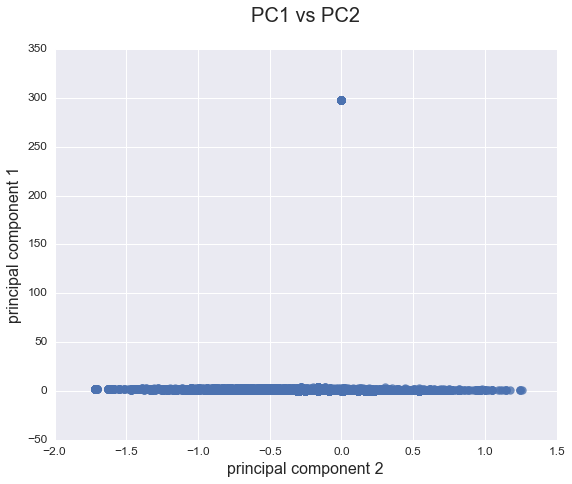

In [101]:
figX = plt.figure(figsize=(9,7))

ax = figX.gca()
ax = sns.regplot(Zx.iloc[:,1], Zx.iloc[:,0],
                 fit_reg=False, scatter_kws={'s':70}, ax=ax)

ax.set_xlabel('principal component 2', fontsize=16)
ax.set_ylabel('principal component 1', fontsize=16)


for tick in ax.xaxis.get_major_ticks():
    tick.label.set_fontsize(12) 
    
for tick in ax.yaxis.get_major_ticks():
    tick.label.set_fontsize(12) 
    
ax.set_title('PC1 vs PC2\n', fontsize=20)

plt.show()

In [102]:
# Will now transform data so that PC1 and PC2 can be plotted with individual feature variables...
# Need to do this in order to see which variables are more likely part of the principal components...


features_noSt_noNum_pcs = features_noSt_noNum.copy

features_noSt_noNum_pcs = (features_noSt_noNum - features_noSt_noNum.mean()) / features_noSt_noNum.std()

features_noSt_noNum_pcs['PC1'] = Zx.iloc[:,0]
features_noSt_noNum_pcs['PC2'] = Zx.iloc[:,1]

In [105]:
features_noSt_noNum = pd.melt(features_noSt_noNum, id_vars=['PC1','PC2'])


KeyError: 'PC1'

In [106]:
features_noSt_noNum.head()

,ILNAsv,AcSuppSv,PSEdSuppSv,CareerSv,EmplyTrSv,BudgetSv,HousEdSv,HlthEdSv,FamSuppSv,MentorSv,SILsv,RmBrdFASv,EducFinaSv,OthrFinaSv,DelinqntSv
7328,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
7329,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7330,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0
7331,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7332,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


### PC1 vs Feature Variables

In [107]:
pc1 = sns.lmplot(x="PC1", y="value", col="variable", hue="variable", 
                 data=features_noSt_noNum, col_wrap=2, size=7, scatter_kws={'s':50})

KeyError: "['PC1' 'value' 'variable'] not in index"

### PC2 vs Feature Variables

In [108]:
pc2 = sns.lmplot(x="PC2", y="value", col="variable", hue="variable", 
                 data=features_noSt_noNum, col_wrap=2, size=7, scatter_kws={'s':50})


KeyError: "['PC2' 'value' 'variable'] not in index"

In [44]:
# From the PCAs so far, can see that State and Num_services should be kept as feature variables for this project

### PC1 vs PC2 WITH LABELS

In [45]:
targets_w2.columns

Index([u'PubFoodAs', u'PubHousAs', u'OthrFinAs', u'HighEdCert', u'CurrFTE',
       u'CurrPTE', u'PubFinAs', u'CurrenRoll', u'PrescripIn', u'Homeless',
       u'SubAbuse', u'Incarc', u'Medicaid', u'OthrHlthIn', u'MedicalIn',
       u'MentlHlthIn'],
      dtype='object')

In [52]:
targets_w2.columns.get_loc('HighEdCert')

3

In [46]:
features_w2.columns

Index([u'ILNAsv', u'AcSuppSv', u'PSEdSuppSv', u'CareerSv', u'EmplyTrSv',
       u'BudgetSv', u'HousEdSv', u'HlthEdSv', u'FamSuppSv', u'MentorSv',
       u'SILsv', u'RmBrdFASv', u'EducFinaSv', u'OthrFinaSv', u'St',
       u'DelinqntSv', u'Num_services'],
      dtype='object')

In [47]:
features_w2.columns.get_loc("ILNAsv")


0

In [48]:
features_w2.columns.get_loc("Num_services")


16

In [53]:
# Establish x and y variables. HighEdCert will be target variable for this analysis...
x = features_w2.ix[:,:].values
y = targets_w2.ix[:,3].values

In [54]:
# Standardize data

from sklearn.preprocessing import StandardScaler

xStand = StandardScaler().fit_transform(x)

In [55]:
# Calculate eigenvectors and eigenvalues from covariance matrix.

covMat = np.cov(xStand.T)
eigenValues, eigenVectors = np.linalg.eig(covMat)

In [56]:
print(eigenValues)
print(eigenVectors)

[  1.50945182e+01   1.02305379e+00   8.76251609e-01   1.17709886e-03
   9.24734867e-04   8.55620092e-04   2.19567369e-04   2.62324593e-04
   3.50894142e-04   7.63728073e-04   4.66186262e-04   6.54545447e-04
   6.24937870e-04   6.02843055e-04   5.59667210e-04   5.24442985e-04
   5.10014035e-04]
[[ -2.57236415e-01  -1.73044856e-02  -2.03174297e-03   8.60481807e-01
    1.91703564e-02  -3.55442337e-01  -4.94770825e-02  -8.21918188e-02
   -7.12224382e-02  -1.01690321e-01   1.11467341e-01  -9.32025788e-03
    3.24657577e-02  -4.89285174e-02   6.05044683e-02   1.48036380e-01
    1.54175659e-02]
 [ -2.57215386e-01  -2.47979348e-02  -5.45591271e-03  -4.24674305e-01
   -3.38158506e-01  -7.23550760e-01  -7.99861723e-03  -7.98585921e-02
   -4.20315939e-02  -5.74375888e-02   1.07191861e-01  -1.32651893e-01
    2.25817372e-01   3.53084255e-02   9.80374039e-03   7.40478162e-02
    1.28675219e-01]
 [ -2.57278580e-01  -2.24585640e-02  -3.20971525e-03  -9.98712557e-03
   -1.01876953e-01   1.12067850e-01

In [57]:
# Sorting eigenpairs from highest to lowest

eigenPairs = [(np.abs(eigenValues[i]), eigenVectors[:,i]) for i in range(len(eigenValues))]
eigenPairs.sort()
eigenPairs.reverse()
for i in eigenPairs:
    print(i[0])

15.0945181775
1.02305379378
0.876251609428
0.00117709886486
0.000924734867375
0.000855620092115
0.000763728072964
0.000654545447156
0.000624937870238
0.000602843054545
0.000559667210326
0.000524442985166
0.000510014034543
0.000466186261671
0.000350894141614
0.000262324593382
0.000219567369246


In [58]:
totalEigen = sum(eigenValues)
varExpl = [(i / totalEigen)*100 for i in sorted(eigenValues, reverse=True)]

In [59]:
print(varExpl)


[88.779166682861515, 6.0171422641843222, 5.1537178447540741, 0.0069231660856251005, 0.005438874561117156, 0.005032372539594202, 0.0044919050142943739, 0.0038497419176340198, 0.0036756034671491791, 0.0035456516990850086, 0.0032917108030937614, 0.0030845377539125756, 0.0029996731562248473, 0.0027418979091190778, 0.0020638015152228883, 0.0015428752694826536, 0.0012913965085270887]


In [60]:
cvarex = np.cumsum(varExpl)


In [61]:
print(cvarex)

[ 88.77916668  94.79630895  99.95002679  99.95694996  99.96238883
  99.9674212   99.97191311  99.97576285  99.97943846  99.98298411
  99.98627582  99.98936036  99.99236003  99.99510193  99.99716573
  99.9987086  100.        ]


In [62]:
from sklearn.decomposition import PCA 


pcask = PCA(n_components=2)
print pcask.fit(xStand).components_ # See the eigenvectors
xPC = pcask.fit_transform(xStand) # Use the eigenvectors to transform xStand onto new axes

[[ 0.25723641  0.25721539  0.25727858  0.25722578  0.25725529  0.25723862
   0.25722745  0.25722399  0.25723804  0.25728006  0.25734203  0.25733059
   0.25731111  0.25727985  0.05398759  0.25730585 -0.06556594]
 [-0.01730449 -0.02479793 -0.02245856 -0.02575801 -0.02373731 -0.02420857
  -0.0265006  -0.02709168 -0.025743   -0.01996722 -0.0152503  -0.01851434
  -0.01883458 -0.02029967  0.74950844 -0.01413495 -0.65647981]]


In [63]:
PCdf = pd.DataFrame(xPC, columns=['PC1','PC2'])


In [64]:
features_2_ = features_w2


In [65]:
features_pca = features_2_.join(PCdf, on=None, how='left')


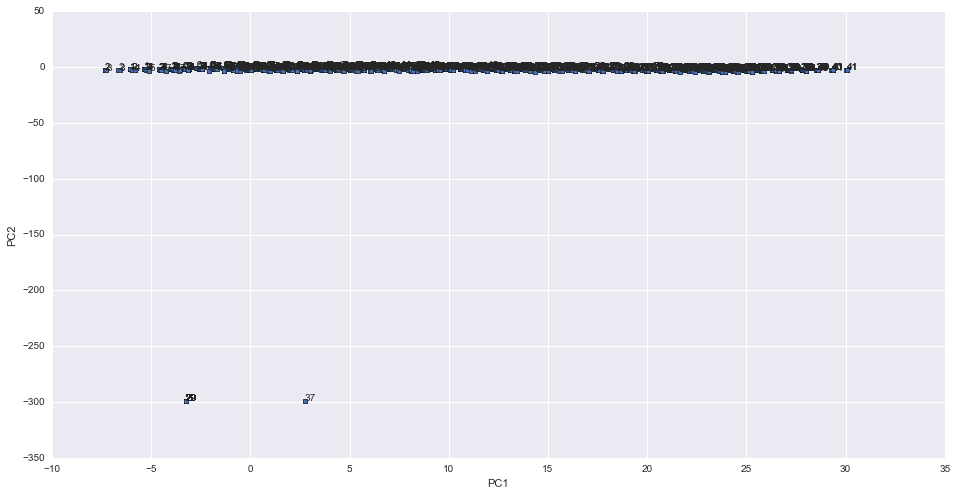

In [66]:
graph = features_pcs.plot(kind='scatter', x='PC1', y='PC2', figsize=(16,8))

for i, feature in enumerate(features_2_['St']):
    graph.annotate(feature, (features_pcs.iloc[i].PC1, features_pcs.iloc[i].PC2))

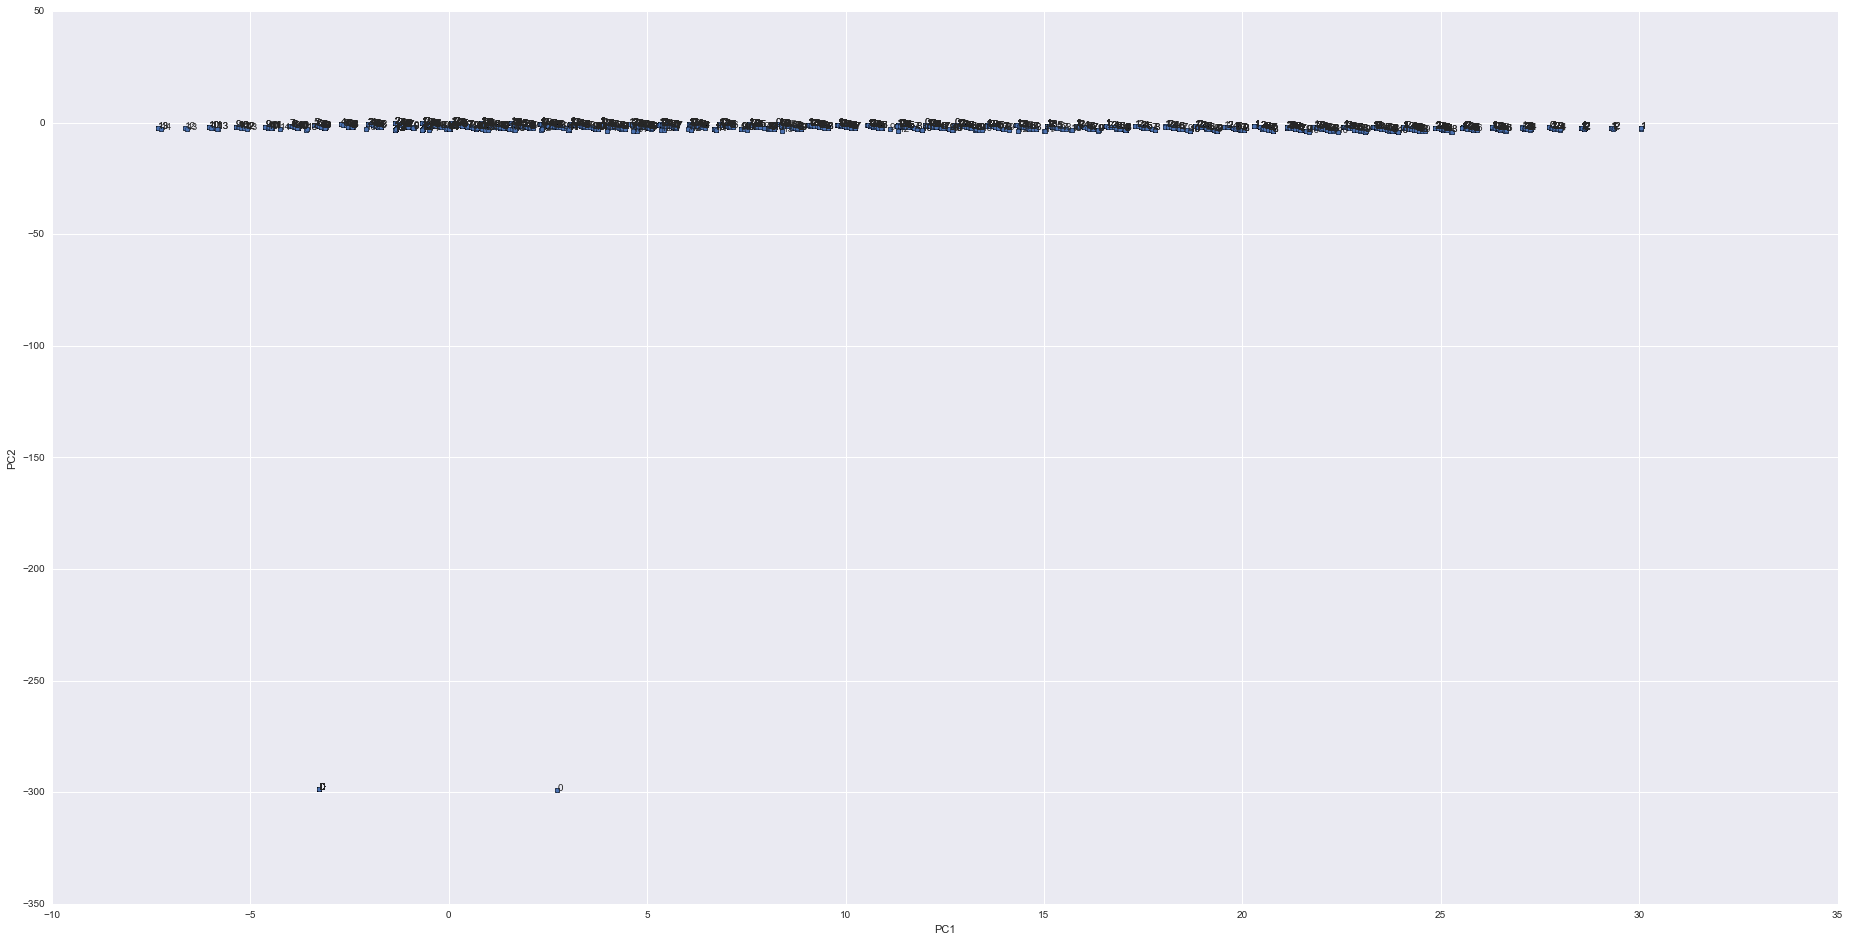

In [68]:
graph = features_pcs.plot(kind='scatter', x='PC1', y='PC2', figsize=(32,16))

for i, feature in enumerate(features_w2['Num_services']):
    graph.annotate(feature, (features_pcs.iloc[i].PC1, features_pcs.iloc[i].PC2))

In [ ]:
# withOUT num_services and state as one feature
features_noNum_st_one

# withOUT states and with num_services
features_noSt

# withOUT states and Num_services
features_noSt_noNum

# Save datsets

In [69]:
features_w2.to_csv('features_w2.csv')
targets_w2.to_csv('targets_w2.csv')
